### About this result

Our training procedure is monitored with `WandbLogger`. This code retrieves the training results using `wandb` `API`.

- Seaborn error options, see [sns.errorbar](https://seaborn.pydata.org/tutorial/error_bars.html)

In [1]:
from collections import defaultdict
from functools import reduce
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from tqdm.contrib.itertools import product as tqdm_product
import wandb

import g_main

api = wandb.Api()
config = g_main.json_config
sns.set_theme()

### Setup counters to check the number of training results.

In [2]:
# Date time id of the training (not exact running time dates).
best_classical = {"date": "20231218", "gnn_out": 1024}
result_date = [
    "20231105", "20231109", "20231110", "20231112",
    "20231113", "20231117", "20231212", 
    best_classical["date"],
]

def check(run: wandb.run):
    """Function for checking the run configuration.

    Args:
        run : wandb.run
            One of the `run` object from `api.runs()`.
    
    Returns:
        Boolean: whether the run is in target training configurations.
    """

    # Check the run state.
    if run.state != "finished":
        return False

    # Check whether the `run` is in the correct date time.
    reduce_func = lambda date_bool, date: date_bool or (date in run.name)
    check_date = reduce(reduce_func, [False] + result_date)

    # Check whether the training configuration is correct.
    check_ml = (run.summary["epoch"] == 30) & (run.config["lr"] == 1E-3)

    return check_date and check_ml

# Counter for different model runs.
counter_dict = defaultdict(int)

for run in api.runs("ntuyianchen/g_main"):
    
    # Check run configuration.
    if not check(run):
        continue
        
    # Additional check for quantum (other configurations have been tested).
    if ("QuantumRotQCGNN" in run.name) and ("gl1" not in run.name):
        continue
    
    # Add corresponding counter.
    model = run.name.split()[0] + " | " + run.config["abbrev"]
    counter_dict[model] += 1

# Print out counters.
counter_keys = list(counter_dict.keys())
counter_keys.sort()
for key in counter_keys:
    if counter_dict[key] == 10:
        print(f"{key}")

ClassicalMPGNN_go1024_gh1024_gl4_mh0_ml0 | BB-QCD
ClassicalMPGNN_go1024_gh1024_gl4_mh0_ml0 | TT-QCD
ClassicalMPGNN_go3_gh3_gl2_mh0_ml0 | BB-QCD
ClassicalMPGNN_go3_gh3_gl2_mh0_ml0 | TT-QCD
ClassicalMPGNN_go6_gh6_gl2_mh0_ml0 | BB-QCD
ClassicalMPGNN_go6_gh6_gl2_mh0_ml0 | TT-QCD
ClassicalMPGNN_go9_gh9_gl2_mh0_ml0 | BB-QCD
ClassicalMPGNN_go9_gh9_gl2_mh0_ml0 | TT-QCD
QuantumRotQCGNN_qidx3_qnn3_gl1_gr3 | BB-QCD
QuantumRotQCGNN_qidx3_qnn3_gl1_gr3 | TT-QCD
QuantumRotQCGNN_qidx3_qnn6_gl1_gr6 | BB-QCD
QuantumRotQCGNN_qidx3_qnn6_gl1_gr6 | TT-QCD
QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | BB-QCD
QuantumRotQCGNN_qidx3_qnn9_gl1_gr9 | TT-QCD


### Retrieve training results on `wandb` and store in a `pandas` data frame

In [3]:
# Data frame for storing results.
df = pd.DataFrame()

# Setup a tqdm for monitoring process.
wandb_runs = api.runs(f"{config['wandb_account']}/{config['wandb_project']}")
for run in tqdm.tqdm(wandb_runs):

    # Check whether the run is our target training result.
    if not check(run):
        continue

    # Since the validation results have different steps than training results, 
    # they should be export independently. Otherwise pandas cannot be created
    # in correct shape.
    hist_train = run.history(
        keys=[
            "epoch", "epoch_time",
            "train_acc_epoch", "train_loss_epoch", "train_roc_auc"
        ],
        x_axis="epoch"
    )
    hist_valid = run.history(
        keys=["valid_acc_epoch", "val_roc_auc"],
        x_axis="epoch"
    )

    # This training result data frame.
    temp_frame = pd.concat(
        [hist_train,  hist_valid[["valid_acc_epoch", "val_roc_auc"]]], axis=1)

    # Set pandas columns of keys (features) we want.
    config_keys = ["model_name", "abbrev", "rnd_seed"]

    if "ClassicalMPGNN" in run.name:
        config_keys += ["gnn_hidden", "gnn_out"]
        temp_frame["legend"] = f"MPGNN(D={run.config['gnn_out']})"

    elif "QuantumRotQCGNN" in run.name:
        if "gl1" not in run.name:
            continue
        config_keys += ["gnn_nn_qubits", "gnn_reupload", "gnn_layers"]
        temp_frame["legend"] = f"QCGNN(D={run.config['gnn_nn_qubits']},R={run.config['gnn_reupload']})"

    for key in config_keys:
        temp_frame[key] = run.config[key]
    
    # Concatenate this training result to total result data frame (df).
    df = pd.concat([df, temp_frame], axis=0)

100%|██████████| 233/233 [02:47<00:00,  1.39it/s]


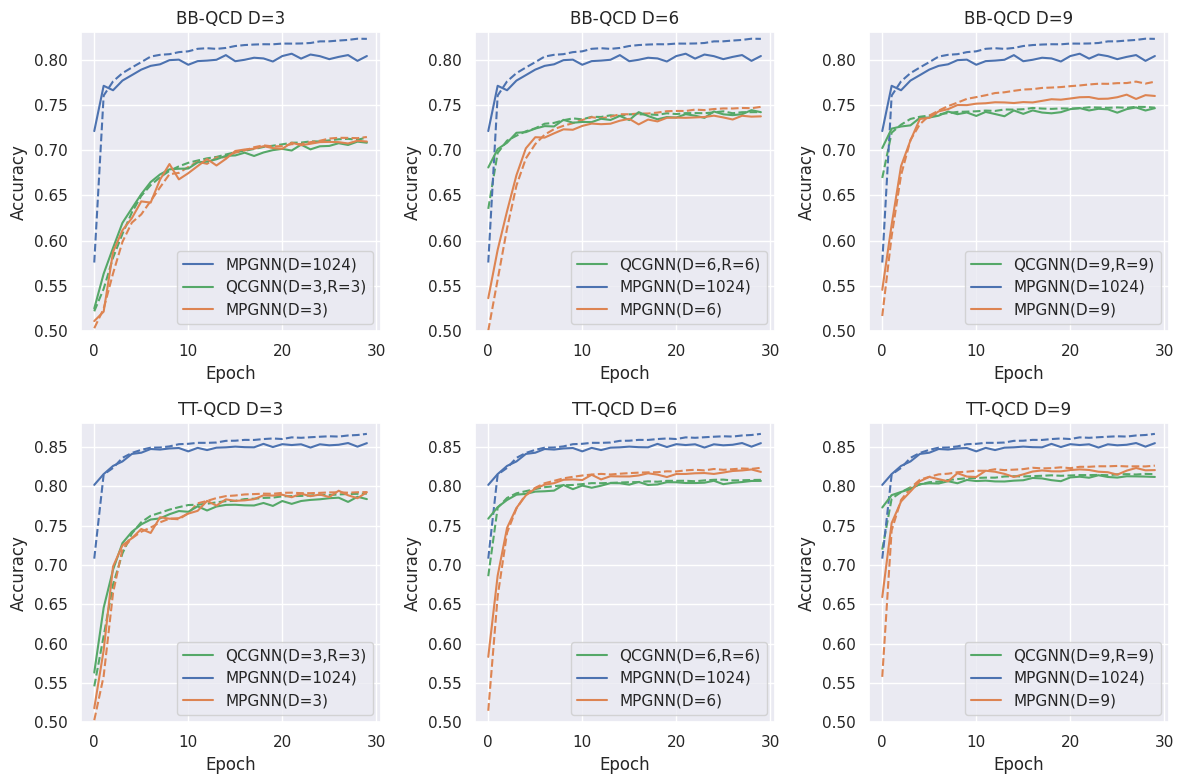

In [4]:
# Channel abbreviations list.
abbrev_list = ["BB-QCD", "TT-QCD"]

# Model dimension list.
dim_list = [3,6,9]

# Figure settings.
num_row = len(abbrev_list)
num_col = len(dim_list)
width, height = 4 * num_col, 4 * num_row
fig, ax = plt.subplots(num_row, num_col, figsize=(width, height))
color_palette = {
    # The key will correspond to seaborn `hue`.
    "MPGNN(D=1024)":"C0",
    "MPGNN(D=3)":"C1", "MPGNN(D=6)":"C1", "MPGNN(D=9)":"C1",
    "QCGNN(D=3,R=3)":"C2", "QCGNN(D=6,R=6)":"C2", "QCGNN(D=9,R=9)":"C2",
}

for row, col in product(range(num_row), range(num_col)):
    abbrev = abbrev_list[row]
    dim = dim_list[col]

    is_abbrev = (df["abbrev"] == abbrev)
    is_classical = (df["gnn_out"] == best_classical["gnn_out"]) \
        | (df["gnn_out"] == dim)
    is_quantum = (df["gnn_nn_qubits"] == dim) & (df["gnn_reupload"] == dim)
    index = is_abbrev & (is_classical | is_quantum)

    # Plot training data procedure and result.
    sns.lineplot(
        data=df[index],
        x="epoch",
        y="train_acc_epoch",
        hue="legend",
        ax=ax[row][col],
        palette=color_palette,
        err_style=None,
        legend=False,
        linestyle='--'
    )

    # Plot testing (validation) data procedure and result.
    sns.lineplot(
        data=df[index],
        x="epoch",
        y="valid_acc_epoch",
        hue="legend",
        ax=ax[row][col],
        palette=color_palette,
        errorbar=None,
        # errorbar=("sd", 1),
    )

    # Setup labels and titles.
    ax[row][col].set_xlabel("Epoch")
    ax[row][col].set_ylabel("Accuracy")
    ax[row][col].set_title(f"{abbrev_list[row]} D={dim_list[col]}")

    # Manually set figures y-axis range (limit).
    if abbrev == "BB-QCD":
        ax[row][col].set_ylim(0.50, 0.83)
    elif abbrev == "TT-QCD":
        ax[row][col].set_ylim(0.50, 0.88)

    # Move the legend bot to bottom right.
    sns.move_legend(ax[row][col], "lower right", title=None)

    plt.tight_layout()